# Классификационное дерево и Random Forest
Дерево решений строит последовательность разбиений признакового пространства, минимизируя неоднородность узлов. Для классификации часто используют критерий Джини $G = 1 - \sum_k p_k^2$ или энтропию $H = -\sum_k p_k \log p_k$. Random Forest обучает множество деревьев на бутстрап-выборках и случайных подмножествах признаков, а итоговое решение получается голосованием большинства: $\hat{y} = \mathrm{mode}(\hat{y}^{(1)}, \ldots, \hat{y}^{(T)})$. Это снижает дисперсию модели и повышает обобщающую способность.


## Используемые библиотеки
Используем `numpy`, `pandas` для работы с данными, `seaborn` и `matplotlib` для визуализации. Из `sklearn` — загрузчик датасета, `train_test_split`, классификаторы `DecisionTreeClassifier` и `RandomForestClassifier`, а также метрики классификации и построение ROC-кривых.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    validation_curve,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
)

sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"
CONFUSION_CMAP = "Blues"


## Датасет: описание и частичная распечатка
Датасет **Breast Cancer Wisconsin** — 569 образцов опухолей, описанных 30 числовыми признаками: средние, стандартные отклонения и экстремальные значения радиуса, текстуры, периметра, площади, гладкости клеток. Целевая переменная — **target**: 0 = злокачественная, 1 = доброкачественная. Задача — бинарная классификация. Классы немного несбалансированы (~37% злокачественных), поэтому используем стратификацию при разбивке.


In [2]:
breast = load_breast_cancer(as_frame=True)
data = breast.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Предварительная обработка
Отделяем признаки от целевой переменной. Разбиваем на train/test (80/20) со стратификацией — это гарантирует одинаковое соотношение классов в обоих разбиениях. Деревья решений не требуют масштабирования признаков, так как работают с пороговыми разбиениями, а не с расстояниями.


In [3]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)


## Тепловая карта корреляций
Матрица из 31 переменной. Заметны сильные корреляции между геометрически связанными признаками: радиус, периметр и площадь коллинеарны ($r > 0.9$). Это мультиколлинеарность — для деревьев она не критична, но полезно знать структуру данных. Признаки с яркими красными квадратами имеют наибольшую связь с целевой переменной.


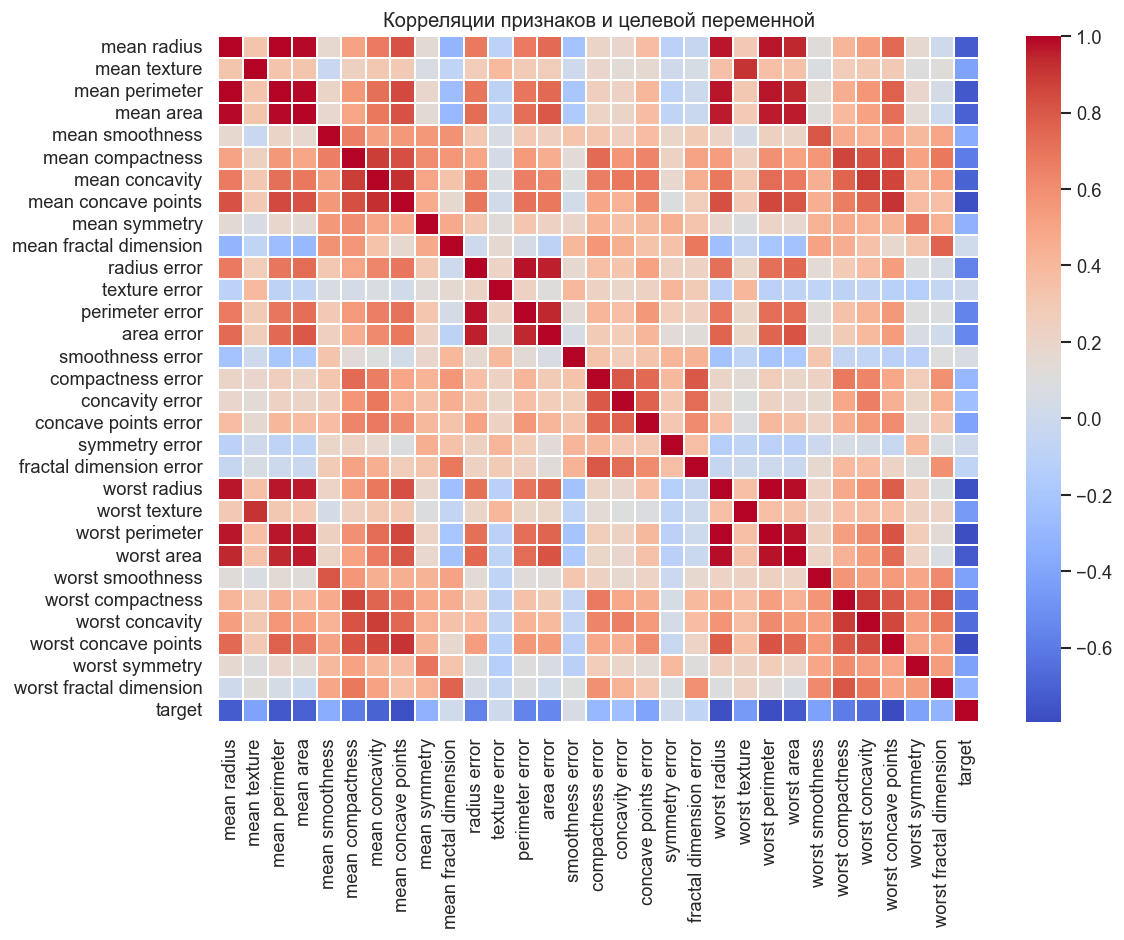

In [4]:
plt.figure(figsize=(10, 8))
correlation = data.corr()
sns.heatmap(correlation, cmap=HEATMAP_CMAP, linewidths=0.2)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Обучение моделей
Сначала обучаем базовые модели:
- **DecisionTree** с `max_depth=4` — ограничиваем глубину для борьбы с переобучением;
- **RandomForest** из 200 деревьев — больше деревьев снижает дисперсию (закон больших чисел), но увеличивает время обучения.

Далее подберем гиперпараметры по **F1** с учетом дисбаланса классов.


In [5]:
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)

tree_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

## Подбор гиперпараметров (F1, быстро)
Используем стратифицированную кросс-валидацию и метрику **F1**. Для учета дисбаланса классов задаем `class_weight="balanced"`.


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [7]:
# Быстрая сетка для дерева решений
# max_depth и min_samples_leaf дают самый заметный эффект на переобучение

tree_param_grid = {
    "max_depth": [1, 3, 5, 7, 10, 50, 100],
    "min_samples_leaf": [1, 2, 4, 6, 50, 100],
    "min_samples_split": [2, 5, 10],
}

tree_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    tree_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True,
)

tree_search.fit(X_train, y_train)
print("Лучшие параметры Decision Tree:", tree_search.best_params_)
print(f"Лучшее CV F1: {tree_search.best_score_:.3f}")


Лучшие параметры Decision Tree: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучшее CV F1: 0.946


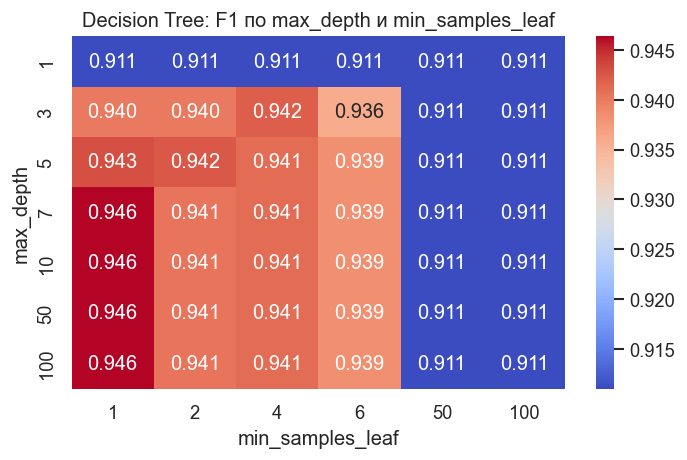

In [8]:
# Heatmap по двум параметрам при фиксированном лучшем min_samples_split

tree_results = pd.DataFrame(tree_search.cv_results_)
best_split = tree_search.best_params_["min_samples_split"]

tree_subset = tree_results[
    tree_results["param_min_samples_split"] == best_split
]

tree_pivot = tree_subset.pivot_table(
    index="param_max_depth",
    columns="param_min_samples_leaf",
    values="mean_test_score",
)

plt.figure(figsize=(6, 4))
sns.heatmap(tree_pivot, annot=True, fmt=".3f", cmap=HEATMAP_CMAP)
plt.title("Decision Tree: F1 по max_depth и min_samples_leaf")
plt.xlabel("min_samples_leaf")
plt.ylabel("max_depth")
plt.tight_layout()
plt.show()


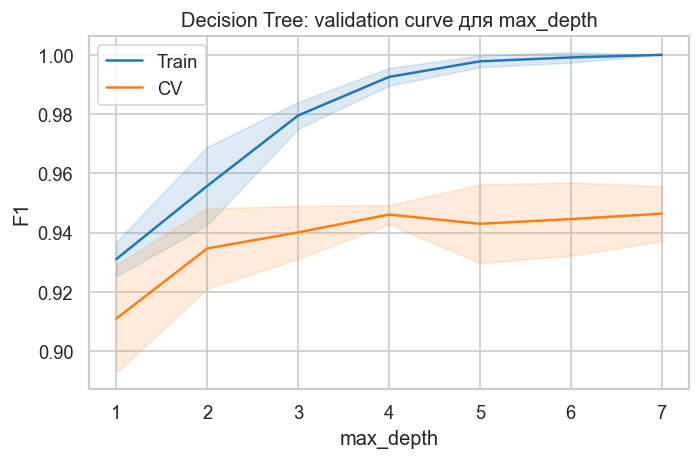

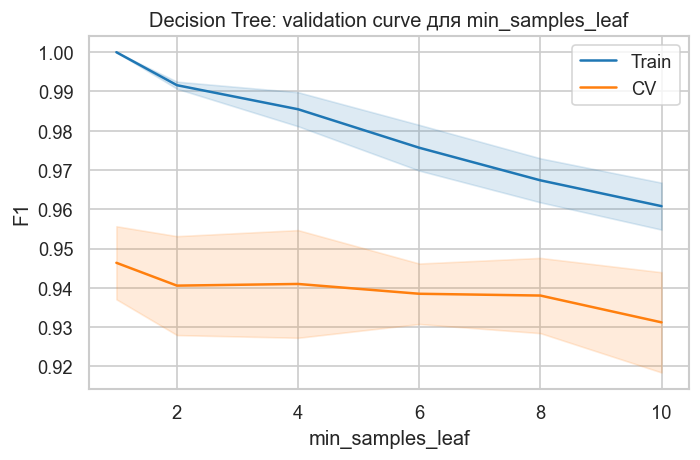

In [9]:
# Validation curves для дерева

def plot_validation_curve(estimator, X, y, param_name, param_range, title):
    train_scores, valid_scores = validation_curve(
        estimator,
        X,
        y,
        param_name=param_name,
        param_range=param_range,
        scoring="f1",
        cv=cv,
        n_jobs=-1,
    )
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    valid_mean = valid_scores.mean(axis=1)
    valid_std = valid_scores.std(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(param_range, train_mean, label="Train", color=PRIMARY_COLOR)
    plt.plot(param_range, valid_mean, label="CV", color=SECONDARY_COLOR)
    plt.fill_between(
        param_range,
        train_mean - train_std,
        train_mean + train_std,
        color=PRIMARY_COLOR,
        alpha=0.15,
    )
    plt.fill_between(
        param_range,
        valid_mean - valid_std,
        valid_mean + valid_std,
        color=SECONDARY_COLOR,
        alpha=0.15,
    )
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("F1")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=[1, 2, 3, 4, 5, 6, 7],
    title="Decision Tree: validation curve для max_depth",
)

plot_validation_curve(
    DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    X_train,
    y_train,
    param_name="min_samples_leaf",
    param_range=[1, 2, 4, 6, 8, 10],
    title="Decision Tree: validation curve для min_samples_leaf",
)


In [10]:
# Быстрая сетка для Random Forest

rf_param_grid = {
    "n_estimators": [80, 120, 200, 1000],
    "max_depth": [3, 5, 7, None],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    rf_param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True,
)

rf_search.fit(X_train, y_train)
print("Лучшие параметры Random Forest:", rf_search.best_params_)
print(f"Лучшее CV F1: {rf_search.best_score_:.3f}")


Лучшие параметры Random Forest: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 120}
Лучшее CV F1: 0.975


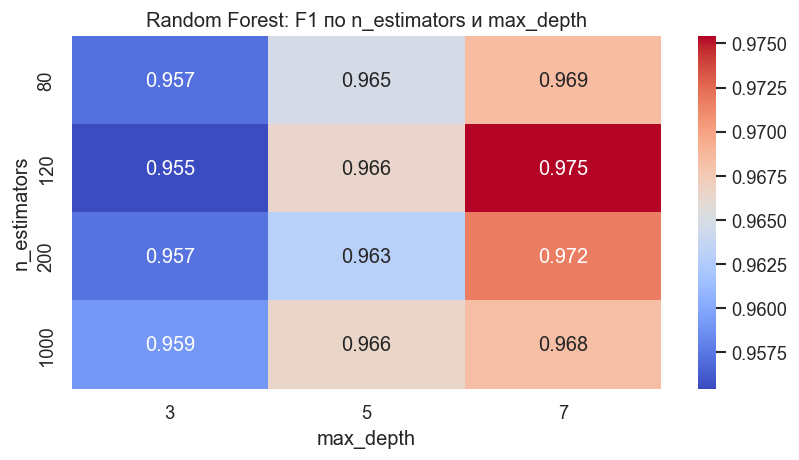

In [11]:
# Heatmap по n_estimators и max_depth при фиксированных лучших min_samples_leaf и max_features

rf_results = pd.DataFrame(rf_search.cv_results_)
best_leaf = rf_search.best_params_["min_samples_leaf"]
best_features = rf_search.best_params_["max_features"]

rf_subset = rf_results[
    (rf_results["param_min_samples_leaf"] == best_leaf)
    & (rf_results["param_max_features"] == best_features)
]

rf_pivot = rf_subset.pivot_table(
    index="param_n_estimators",
    columns="param_max_depth",
    values="mean_test_score",
)

plt.figure(figsize=(7, 4))
sns.heatmap(rf_pivot, annot=True, fmt=".3f", cmap=HEATMAP_CMAP)
plt.title("Random Forest: F1 по n_estimators и max_depth")
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.tight_layout()
plt.show()


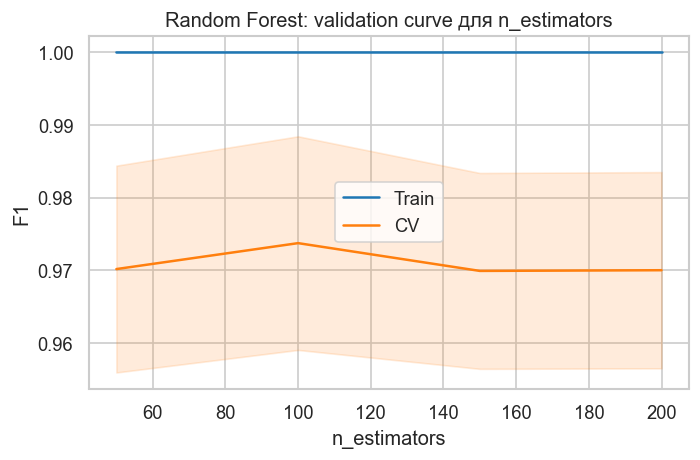

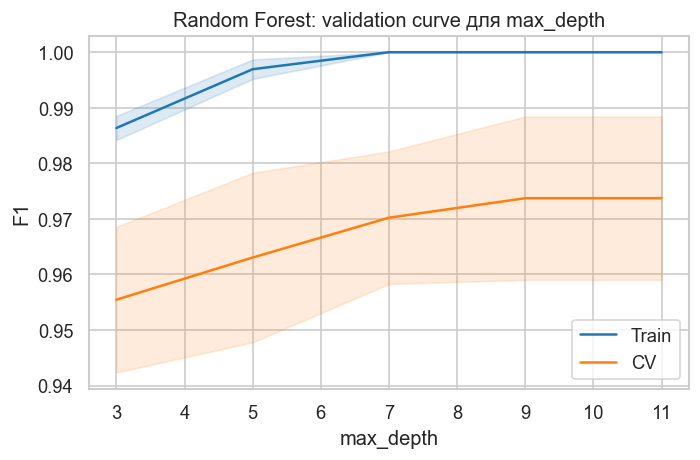

In [12]:
# Validation curves для Random Forest

plot_validation_curve(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=[50, 100, 150, 200],
    title="Random Forest: validation curve для n_estimators",
)

plot_validation_curve(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    X_train,
    y_train,
    param_name="max_depth",
    param_range=[3, 5, 7, 9, 11],
    title="Random Forest: validation curve для max_depth",
)


In [13]:
# Используем лучшие модели для дальнейшей оценки

tree_clf = tree_search.best_estimator_
rf_clf = rf_search.best_estimator_


## Прогнозы моделей
Сравниваем четыре классификационные метрики для каждой модели:
- **Accuracy** — доля верных предсказаний (может вводить в заблуждение при дисбалансе);
- **Precision** — точность: из предсказанных положительных, сколько верных;
- **Recall** — полнота: из всех реальных положительных, сколько нашли;
- **F1** — гармоническое среднее Precision и Recall.

Random Forest ожидаемо превзойдет одиночное дерево.


In [14]:
models = {
    "Decision Tree": tree_clf,
    "Random Forest": rf_clf,
}

for name, model in models.items():
    preds = model.predict(X_test)
    print(f"{name}")
    print(f"Accuracy:  {accuracy_score(y_test, preds):.3f}")
    print(f"Precision: {precision_score(y_test, preds):.3f}")
    print(f"Recall:    {recall_score(y_test, preds):.3f}")
    print(f"F1:        {f1_score(y_test, preds):.3f}")
    print("-")


Decision Tree
Accuracy:  0.930
Precision: 0.957
Recall:    0.931
F1:        0.944
-
Random Forest
Accuracy:  0.947
Precision: 0.958
Recall:    0.958
F1:        0.958
-


## Графики выходных результатов
**График 1. Матрицы ошибок (Confusion Matrix).** Строки — истинный класс, столбцы — предсказанный. Диагональ — верные предсказания. Внедиагональные элементы: **FP** (ложная тревога) и **FN** (пропущенный злокачественный случай). В медицинских задачах FN особенно дорогостоящие.

**График 2. ROC-кривые.** AUC (площадь под кривой) = 1 — идеальный классификатор, = 0.5 — случайный. Чем выше и левее кривая, тем лучше модель. Random Forest, как правило, дает AUC > Decision Tree.


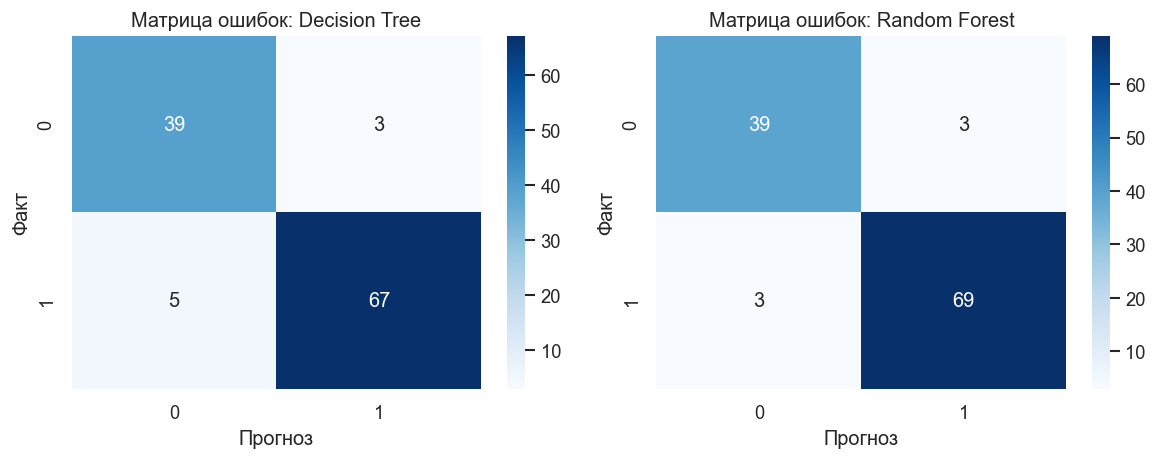

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (name, model) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, fmt="d", cmap=CONFUSION_CMAP, ax=ax)
    ax.set_title(f"Матрица ошибок: {name}")
    ax.set_xlabel("Прогноз")
    ax.set_ylabel("Факт")

plt.tight_layout()
plt.show()


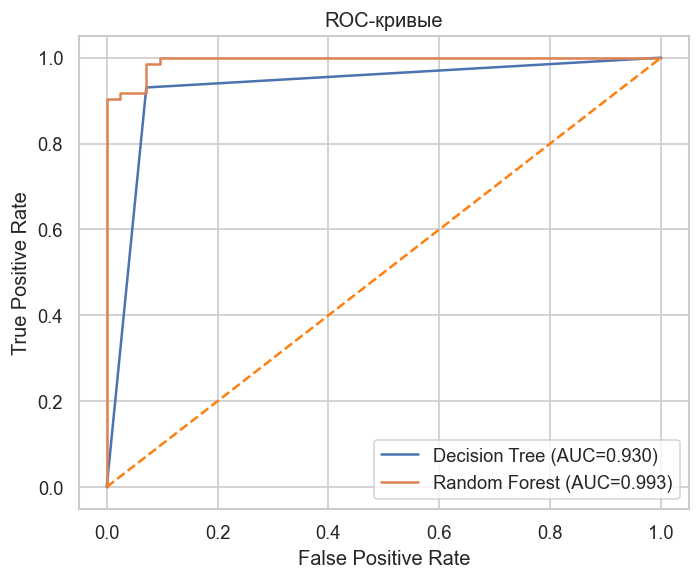

In [16]:
plt.figure(figsize=(6, 5))
colors = sns.color_palette("deep", n_colors=len(models))
for (name, model), color in zip(models.items(), colors):
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})", color=color)

plt.plot([0, 1], [0, 1], color=SECONDARY_COLOR, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые")
plt.legend()
plt.tight_layout()
plt.show()
